# Dark Skies Mass Estimation

We will start by looking at the particle mass density profiles for halos in the Dark Skies.

Make sure you have studied the previous Notebook which describes the mathematical underpinnings of what we are doing: Escape Velocity Cluster Mass Estimation 

The libraries we will use:

In [1]:
aws = False
if (aws == True):
    import sys
    !{sys.executable} -m pip install weave
    !{sys.executable} -m pip install emcee
    !{sys.executable} -m pip install corner
    !{sys.executable} -m pip install fastkde

In [2]:
import astropy.io.fits as fits
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')
import warnings
import scipy.special as spec
warnings.filterwarnings("ignore")
from itertools import cycle
from scipy.interpolate import interp1d
import weave
from weave import converters
import pickle
from IPython.core.debugger import Tracer
from astropy.table import Table
from ipywidgets import FloatProgress
from IPython.display import display
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import multiprocessing
import emcee
import corner
import pdb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import scipy
from escape_functions_noastropy import *
from astropy.cosmology import FlatLambdaCDM
from fastkde import fastKDE
from __future__ import print_function
import time

The Cosmology of Dark Skies and the location of the data.

In [3]:
Omega_m = 0.3089
Omega_L = 0.6911
G_mpc = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 Msol
h0 = 0.6880620000000001
H0 = h0*100.0
sizempc = 10.0 
binsmpc = 100.0
Msun=1.989e30
G_grav=6.67408e-11 
resolution = 0.088670991*1e10#*h0 gives Msol/h, like halo masses

In [4]:
clus_num = 10

if (aws == False):
    root_halos ='/nfs/Christoq2/christoq/research4_new/caustics/darkskies/himass/'
    root_part = '/nfs/Christoq1/pvans/halo_catalogs/goodhalos/'
    root_subhalos = root_part
    root_density = '/nfs/Christoq2/christoq/research4_new/caustics/darkskies/himass/results/dens_ein_origxyz/'
    root_edges = '/nfs/Christoq2/christoq/research4_new/caustics/darkskies/himass/edges/'
else:
    root_halos ='darkskies/himass/'
    root_part = 'halo_catalogs/goodhalos/'
    root_subhalos = 'z_0/z_0_subhalos/'
    root_escape = 'darkskies/himass/escape/'
    root_density = 'darkskies/himass/results/dens_ein_origxyz/'
    root_edges  = 'darkskies/himass/edges/'

This is a cosmolog|y helper function that I often use. It is not really needed here, since the Dark Skies is just a flat $\Lambda$CDM. But I keep it for simplicity.

In [5]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

In [6]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=H0,Om0=Omega_m,name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [7]:
# Do I need this at all? If so, only for aws
if (aws == True): 
    import boto3
    region = boto3.Session().region_name
    bucket='darkskies' # Replace with your s3 bucket name
    bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

Read in the list of halos and their known properties

In [8]:
dt = [('HaloId', long),('m200crit',np.float64),('px',float),('py',float),('pz',float),('vx',float),('vy',float),('vz',float)]
if (aws == False): 
    filename =  root_halos + 'good_halos_tot.dat'
    cluster_list =  np.loadtxt(filename, dtype=dt,skiprows=0) 
else:
    filename ='good_halos_tot.dat'
    s3_filename = root_halos + filename
    local_filename =  'tmp_ds/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    time.sleep(3)
    cluster_list = fits.getdata(local_filename)
    cluster_list =  np.loadtxt(local_filename, dtype=dt,skiprows=0) 

Read in the previously measured shape profiles (in the following case, from the Einasto fits). 

Other choices include a "Dehnen" or "gamma" profile, or an NFW profile. We can also choose different ways to define the center of the halo. origxyz means that we use the original halo position from the catalog.

In [9]:
# Read in the density profile fits (for all clusters in this snapshot)
if (aws == False): 
    filename = 'ds_ein_concentrations_origxyz.dat'
    local_filename =  root_density + filename
    dt = [('HaloId',long), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
    density_prof =  np.loadtxt(local_filename, dtype=dt,skiprows=0) 
else:
    filename = 'ds_ein_concentrations_origxyz.dat'
    s3_filename =  root_density + filename
    local_filename = 'tmp_ds/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    dt = [('HaloId',long), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
    time.sleep(5)
    density_prof =  np.loadtxt(local_filename, dtype=dt,skiprows=0)

Read in the particles and the sub-halos for cluster # clus_num

In [18]:
# Read in the particle data
if (aws == False): 
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '.0_particles.fits' 
    local_filename = root_part + filename
    particles = fits.getdata(local_filename)
else:
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '.0_particles.fits' 
    s3_filename =  root_part + filename
    local_filename = 'tmp_ds/' + filename
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    time.sleep(5)
    particles = fits.getdata(local_filename)

In [19]:
# Read in the sub-halo data
if (aws == False): 
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '.0_subhalos.fits' 
    local_filename = root_part + filename
    subhalos = fits.getdata(local_filename)
else:
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '.0_subhalos.fits' 
    s3_filename =  root_part + filename
    local_filename = 'tmp_ds/' + filename
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    time.sleep(5)
    subhalos = fits.getdata(local_filename)

In [53]:
#create filenames for tables to be created below
if (aws == False): 
    vesc_data_theta_filename = root_edges + 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data_theta.fits'
    vesc_data_filename = root_edges + 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data.fits'
    vesc_data_r_filename = root_edges + 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_r_data.fits'
    vesc_data_err_filename = root_edges + 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_err_data.fits'
    mass_fit_filename = root_edges + 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_mass_fit.txt'
else:
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data_theta.fits'
    vesc_data_theta_local_filename = 'tmp/' + filename
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data.fits'
    vesc_data_local_filename = 'tmp/' + filename
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data_r.fits'
    vesc_data_r_local_filename = 'tmp/' + filename
    filename = 'halo_' + str(cluster_list['HaloId'][clus_num]) + '_vesc_data_err.fits'
    vesc_data_err_local_filename = 'tmp/' + filename   
    mass_fit_local_filename = 'tmp/halo_' + str(cluster_list['HaloId'][clus_num]) + '_mass_fit.txt'

# Read in previously calculated density profiles
if (aws == False): 
    filename = 'tng_halo_99_' + str(cluster_list['ID'][clus_num]) + '_cum_dens.fits'
    local_filename =  root_halos + filename
    density_cumul = fits.getdata(local_filename)
else:
    filename = 'tng_halo_99_' + str(cluster_list['ID'][clus_num]) + '_cum_dens.fits'
    s3_filename = root_halos + filename
    local_filename = 'tmp/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    density_cumul = fits.getdata(local_filename)

In [20]:
z = 0.001
a_halo = 1.0/(1+z)
Halo_v = [cluster_list['vx'][clus_num],cluster_list['vy'][clus_num],cluster_list['vz'][clus_num]]
Halo_p = [cluster_list['px'][clus_num]*a_halo,cluster_list['py'][clus_num]*a_halo,cluster_list['pz'][clus_num]*a_halo] #Note: this is the position in the Guo snapshot. These are zero for particle fits (I.e., do not use with particles)
txt = 'Halo ID: ', cluster_list['HaloId'][clus_num]
print(txt)
txt = 'Halo px,py,pz = ',Halo_p
print(txt)
txt = 'Halo vx,vy,vz = ', Halo_v
print(txt)

('Halo ID: ', 9772120)
('Halo px,py,pz = ', [60.56752247752249, 372.5433806193807, 182.01447252747255])
('Halo vx,vy,vz = ', [-199.970001, -1.21, -586.549988])


The particles and sub-halos are in co-moving coordinates. Switch to physical coordinates by using the Dark Universe scale size for this snapshot's redshift

In [21]:
ppx = particles['pos_x']*a_halo # convert to physical coords
ppy = particles['pos_y']*a_halo
ppz = particles['pos_z']*a_halo
print(len(ppx))
ppx = ppx - Halo_p[0]
ppy = ppy - Halo_p[1]
ppz = ppz - Halo_p[2]

2798223


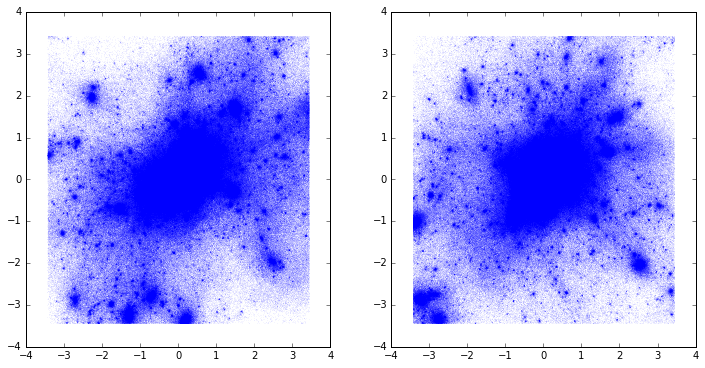

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx,ppy,'.',ms=0.05)
ax[1].plot(ppy,ppz,'.',ms=0.05)

Everything we process is in h-inverse units. Let us switch to physical coordinates with no h scaling:

In [23]:
ppx = ppx/h0
ppy = ppy/h0
ppz = ppz/h0

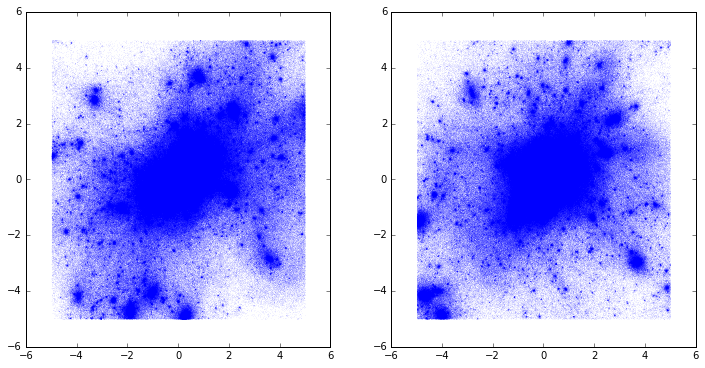

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx,ppy,'.',ms=0.05)
ax[1].plot(ppy,ppz,'.',ms=0.05)

At this point, we should be seeing 5x5Mpc boxes, which was what was extracted in this data.

In [25]:
gal_ppx = subhalos['pos_x']*a_halo # convert to physical coords
gal_ppy = subhalos['pos_y']*a_halo
gal_ppz = subhalos['pos_z']*a_halo
gal_ppx = gal_ppx - Halo_p[0]
gal_ppy = gal_ppy - Halo_p[1]
gal_ppz = gal_ppz - Halo_p[2]
gal_ppx = gal_ppx/h0
gal_ppy = gal_ppy/h0
gal_ppz = gal_ppz/h0

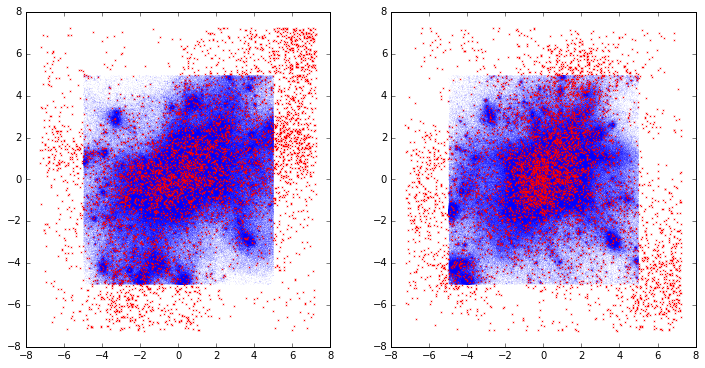

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx,ppy,'.',ms=0.05)
ax[0].plot(gal_ppx, gal_ppy, 'rx',ms=1.5)
ax[1].plot(ppy,ppz,'.',ms=0.05)
ax[1].plot(gal_ppy, gal_ppz, 'rx',ms=1.5)

Note that the sub-halos were extracted at in a large box than the particles. This is probably an H0 issue. Paige will investigate. The alignment is great as expected. So no issues caused by this extraction issue.

Now let's calculate the DM density profile and compare to the fit.

In [28]:
rpart = np.sqrt(ppx**2 + ppy**2 + ppz**2)
dens_radius_bookends = np.linspace(0,5,100)
density = []
cumul_density = []
dens_radius = []
for i in range(99):
    dens_radius = np.append(dens_radius, (dens_radius_bookends[i+1] + dens_radius_bookends[i])/2.0)
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0 - dens_radius_bookends[i]**3.0 )
    count = len(np.where((rpart > dens_radius_bookends[i]) & (rpart < dens_radius_bookends[i+1]))[0])
    density = np.append(density,count*resolution/volume)
    count = len(np.where((rpart < dens_radius_bookends[i+1]))[0])
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0)
    cumul_density = np.append(cumul_density, count*resolution/volume)

Note that we calculate drho/dr (the differential density or density/delta volume) and the cumulative density profile.

The latter is necessary to compare to the M200 published by the Dark Skies team.

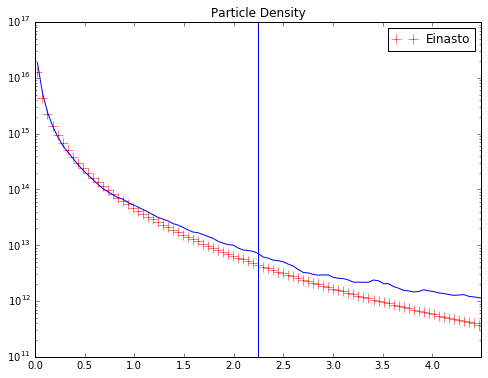

('Our inferred DM log10(M200_crit) = ', 15.107405895715937)
('DS reported log10(m200crit) = ', 15.110697350715009)


In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(dens_radius, rho_einasto(dens_radius,density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]),'+',color='r',ms=10,label='Einasto')
ax.plot(dens_radius, density)
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
r200 = dens_radius[np.where(cumul_density < 200*rho_crit.value)[0][0]]
ax.set_yscale('log')
ax.set_title('Particle Density')
ax.set_xlim(0,2*r200)
ax.legend()
ax.axvline(r200)
plt.show()
w = np.where(rpart < r200)[0]
mass200 = len(w)*resolution
text = 'Our inferred DM log10(M200_crit) = ', np.log10(mass200)
print(text)
text = 'DS reported log10(m200crit) = ', np.log10(cluster_list['m200crit'][clus_num]/h0)
print(text)

What about M200 from the Einasto fit? From the above plot (left), it looks like Einasto will underestimate the M200.

In [36]:
len_r = len(dens_radius)
len_r_interp = 9999
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
r_denfit = np.linspace(np.min(dens_radius),np.max(dens_radius),len_r).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
r_interp = np.linspace(np.min(dens_radius)+0.001,np.max(dens_radius)-0.001,len_r_interp).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.    
M200_fitted = []
R200_fitted = []
rho_r = []
for j in range(len_r):
            rho_r = np.append(rho_r,4*np.pi*integrate.quad(rho_einasto_int,0,r_denfit[j],args=(density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]))[0]/(4/3.*np.pi*(r_denfit[j]**3.0)))
log10_rho_r_func = interp1d(dens_radius, np.log10(rho_r), kind='quadratic')
log10_rho_r_interp = log10_rho_r_func(r_interp)
w = np.where(log10_rho_r_interp < np.log10(200*rho_crit.value))[0]
if (len(w) >0):
        R200_fitted = np.append(R200_fitted,r_interp[w[0]])
        M200_fitted = np.append(M200_fitted, 4*np.pi*integrate.quad(rho_einasto_int,0,r_interp[w[0]],args=(density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]))[0])
text = 'The Einasto inferred DM log10(M200) = ', np.log10(M200_fitted[0])
print(text)
text = 'The DS log10(m200crit) = ', np.log10(cluster_list['m200crit'][clus_num]/h0)
print(text)

('The Einasto inferred DM log10(M200) = ', 15.028692201276524)
('The DS log10(m200crit) = ', 15.110697350715009)


## Phase-space mass estimation.

Next, let us look at the phase-space data of the sub-halos and/or galaxies.

First, let's look at this in "3D" by calculating the radial (or tangential) velocities of any particle. 

In [39]:
vvx = particles['vel_x']
vvy = particles['vel_y']
vvz = particles['vel_z']
gal_rpart = np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0)
gal_vvx = subhalos['vel_x'] #Convert from Halo Finder units to physical units (only for particles)
gal_vvy = subhalos['vel_y']
gal_vvz = subhalos['vel_z']
wr200 = np.where(rpart < r200)[0]
gal_vvx = gal_vvx - np.mean(vvx[wr200])
gal_vvy = gal_vvy - np.mean(vvy[wr200])
gal_vvz = gal_vvz - np.mean(vvz[wr200])
Ngal = len(np.where((gal_rpart > 0.3*r200) & (gal_rpart < r200))[0])
text ='3D Phase-space richness = ', Ngal
print(text)
gal_vpart = np.sqrt(gal_vvx**2.0 + gal_vvy**2.0 + gal_vvz**2.0)
thetavec = np.arccos(gal_ppz/np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0))
phivec = np.arctan2(gal_ppy,gal_ppx)
gal_vtheta = gal_vvx*np.cos(thetavec)*np.cos(phivec) + gal_vvy*np.cos(thetavec)*np.sin(phivec) - gal_vvz*np.sin(thetavec)
gal_vphi = -gal_vvx*np.sin(phivec) + gal_vvy*np.cos(phivec)
gal_vrad = gal_vvx*gal_ppx/ gal_rpart + gal_vvy*gal_ppy/gal_rpart + gal_vvz*gal_ppz/gal_rpart # calculate the radial component of the velocities
vflow = cosmo.H(z).value*gal_rpart
gal_vr_tot = gal_vrad + vflow # Add in the Hubble flow
gal_vtan = np.sqrt(gal_vtheta**2.0 + gal_vphi**2.0)

('3D Phase-space richness = ', 920)


Now, make a theory prediction for this cluster given the statistical under-sampling of the phase-space (Ngal). Use the Dark Skies m200crit.

In [40]:
radial_bins = 10
M200_orig = np.log10(cluster_list['m200crit'][clus_num]/h0)
M200_use = np.repeat(10**M200_orig,(1))
z = np.array((0.01))
z = np.repeat(z,(1))
N = np.repeat(Ngal,len(z))
#N = np.repeat(1e8,len(z))
num_clus = 1
rho_0 = np.repeat(density_prof['rho_0'][clus_num],(1))
h = np.repeat(density_prof['h'][clus_num],(1))
n = np.repeat(density_prof['n'][clus_num],(1))
radius_array = np.linspace(0.1,3.5,radial_bins).round(3) #specify radius array for profiles in Mpc
theta_data = np.zeros((1,radial_bins))
theta_data[0,:] = radius_array /D_A(z[0], cosmo_params, cosmo.name) #calculate the angular radial coordinates in some cosmology
r_NFW,vesc_NFW = v_esc_NFW_M200(theta_data,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

Now plot the phase-space (of radial velocities) and put on the theory.

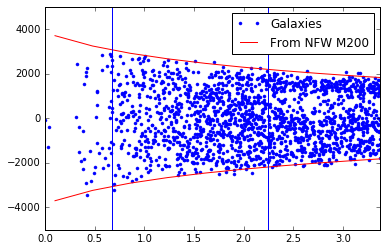

In [41]:
plt.plot(gal_rpart, gal_vr_tot, '.', label = 'Galaxies')
plt.plot(r_NFW[0],vesc_NFW[0], 'r',label = 'From NFW M200')
plt.plot(r_NFW[0],-vesc_NFW[0], 'r')
plt.xlim(0,1.5*r200)
plt.ylim(-5000,5000)
plt.axvline(0.3*r200)
plt.axvline(r200)
plt.legend()
plt.show()

The range between the lines is 0.3r200 to r200. We will use the "3D" (or radial) escape profile (which is suppressed) to measure an edge and try and infer back the mass. Obviously, we should do pretty well.

This has more or less been investigated in [Miller et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/822/1/41) . While they did not use the 3D information to infer the masses, they did show that the escape theory can predict the escape edge to high precision and accuracy for the Millennium. The reverese would have to be true.

Instead of conducting the exercise already proven, we simply show the results:

In [42]:
from IPython.display import Image

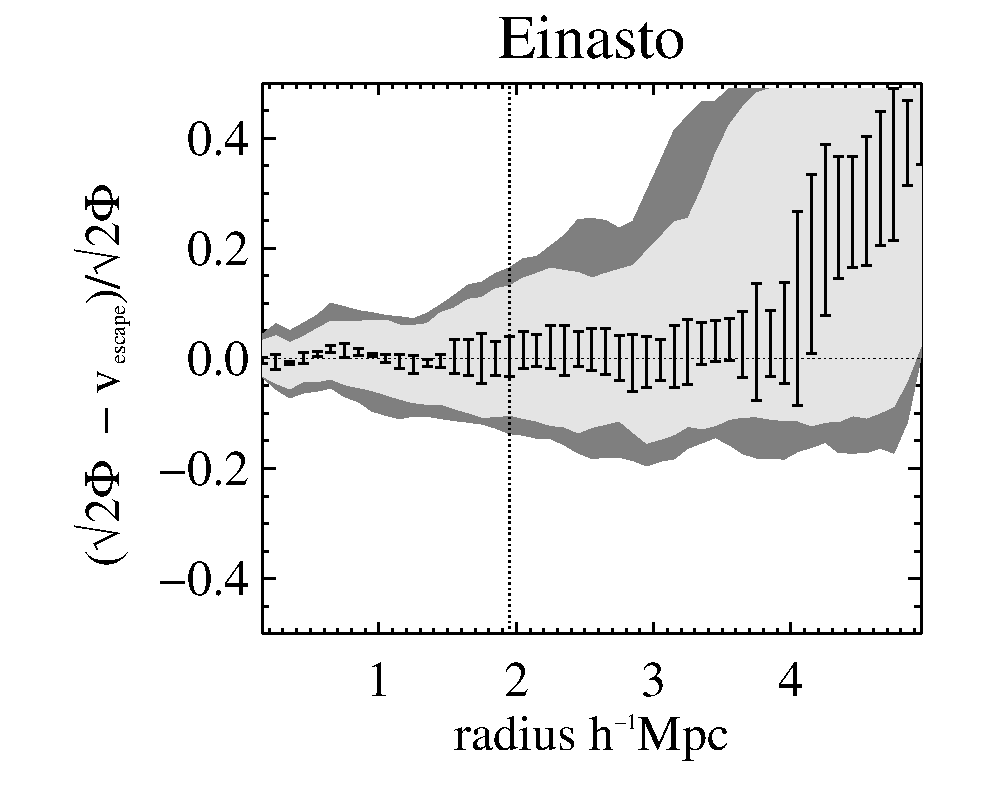

In [43]:
Image(filename='ein_edge_sqrtpot_frac_ds_default.png')

The above image uses the hi-mass sample of Dark Skies clusters. Inside the virial average virial radius (vertical line), the accuracy is 0.3% and the cluster-to-cluster scatter is 5%. These are both better than what was measured for the Millennium.

Define the code and functions required to make the line-of-sight projections

In [44]:
def Pick_pos(halop):
    x = np.random.uniform(-1,1)
    y = np.random.uniform(-1,1)
    z = np.random.uniform(-1,1)
    unit = np.array([x,y,z])/(x**2+y**2+z**2)**(.5)
    return unit

In [45]:
def perpendicular_vector(v):
    r""" Finds an arbitrary perpendicular vector to *v*."""
    # for two vectors (x, y, z) and (a, b, c) to be perpendicular,
    # the following equation has to be fulfilled
    #     0 = ax + by + cz

    # x = y = z = 0 is not an acceptable solution
    if v[0] == v[1] == v[2] == 0:
        raise ValueError('zero-vector')

    # If one dimension is zero, this can be solved by setting that to
    # non-zero and the others to zero. Example: (4, 2, 0) lies in the
    # x-y-Plane, so (0, 0, 1) is orthogonal to the plane.
    if v[0] == 0:
        return [1, 0, 0]
    if v[1] == 0:
        return [0, 1, 0]
    if v[2] == 0:
        return [0, 0, 1]

    # arbitrarily set a = b = 1
    # then the equation simplifies to
    #     c = -(x + y)/z
    return [1, 1, -1.0 * (v[0] + v[1]) / v[2]]

This function is written in the language C. We will use the libary weave to make this call externally via the WEAVE library. You will need to make sure this is installed and working for you. The use of C helps speed things up.

In [46]:
code = """
       int u,w;
       for (u=0;u<n;++u){
       for(w=0;w<3;++w){
           gal_pos_vect(w,u) = (gal_p(w,u)-new_pos(w))/gal_dist(u);
           }
       gal_vlos(u) = gal_pos_vect(0,u)*gal_v(0,u)+gal_pos_vect(1,u)*gal_v(1,u)+gal_pos_vect(2,u)*gal_v(2,u);
       }
       """

In [47]:
gal_v = np.array([gal_vvx,gal_vvy,gal_vvz])
gal_p = np.array([gal_ppx,gal_ppy,gal_ppz])
rotdo_vec = np.linspace(0,180,num = 30)
rotdo = 1
r1_vec = np.zeros((len(gal_p[0]),rotdo))
v1_vec = np.zeros((len(gal_p[0]),rotdo))

for i in range(rotdo):
    prefactor = np.random.randint(0,180)
    prefactor = rotdo_vec[i]
    new_pos = np.array((60*np.cos(prefactor*np.pi/180.0),60*np.sin(prefactor*np.pi/180.0),0))
    halo_dist = ((new_pos[0])**2 + (new_pos[1])**2 + (new_pos[2])**2)**0.5
    halo_pos_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
    halo_vlos = np.dot(halo_pos_vect, Halo_v[:])
    gal_dist = ((gal_p[0]-new_pos[0])**2 + (gal_p[1]-new_pos[1])**2 + (gal_p[2]-new_pos[2])**2)**0.5
    gal_vlos = np.zeros(gal_dist.size)
    n = gal_dist.size
    gal_pos_vect = np.zeros((3,gal_dist.size))
    fast = weave.inline(code,['gal_pos_vect','n','gal_dist','gal_vlos','gal_v','new_pos','gal_p'],type_converters=converters.blitz,compiler='gcc')
    r1 = (halo_dist**2-np.dot(halo_pos_vect*halo_dist,gal_pos_vect)**2)**0.5
    v1 = gal_vlos-halo_vlos*np.dot(halo_pos_vect,gal_pos_vect) 
    r1_vec[:,i] = r1
    v1_vec[:,i] = v1

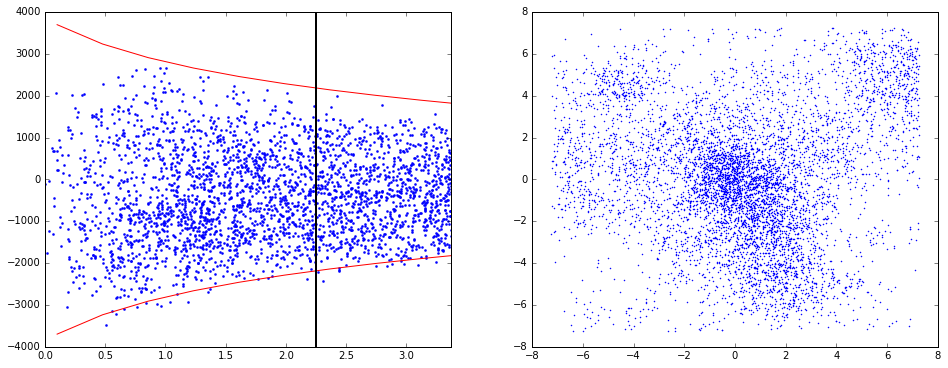

In [48]:
#Take last one and plot it (if true)
PLOTIT = True
if PLOTIT:
    normal_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
    perp_vector = perpendicular_vector(normal_vect)
    perp_vector = (perp_vector[0],perp_vector[1],perp_vector[2]) /np.sqrt(perp_vector[0]**2.0 + perp_vector[1]**2.0 + perp_vector[2]**2.0)
    galx_rel = np.subtract(gal_ppx,new_pos[0])
    galy_rel = np.subtract(gal_ppy,new_pos[1])
    galz_rel = np.subtract(gal_ppz,new_pos[2])
    gal_projx = np.zeros(len(galx_rel))
    gal_projy = np.zeros(len(galy_rel))
    
    for kk in range(len(galx_rel)):
        gal_projx[kk] = np.dot([galx_rel[kk],galy_rel[kk],galz_rel[kk]], perp_vector)
        gal_projy[kk] = np.dot([galx_rel[kk],galy_rel[kk],galz_rel[kk]], np.cross(normal_vect,perp_vector))
    rdist = []
    for kk in range(len(galx_rel)):
        rdist = np.append(rdist,np.sqrt((gal_projx[kk])**2.0 + (gal_projy[kk])**2.0) ) 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(r1_vec,v1_vec,'.',ms =4)
    ax[0].plot(r_NFW[0], vesc_NFW[0],'r-')
    ax[0].plot(r_NFW[0], -vesc_NFW[0],'r-')
    ax[0].axvline(r200,color='k',linewidth=2)
    ax[0].set_xlim(0,1.5*r200)
    #    plt.plot(r_NFW[0],-vesc_NFW[0],'r-')
    ax[1].plot(gal_projx,gal_projy,'.',ms=2)
    plt.show()

In [49]:
rbins = 10
binsize = (1.0-0.3)*r200/rbins

r_fit = np.zeros((rbins,rotdo))
v_fit_max = np.zeros((rbins,rotdo))
v_fit_minmax = np.zeros((rbins,rotdo))
v_fit_minmaxavg = np.zeros((rbins,rotdo))
v_fit_max_cored = np.zeros((rbins,rotdo))
v_fit_range = np.zeros((rbins,rotdo))
radius_min = 0.3*r200
for j in range(rotdo):
    r_min = radius_min
    for i in range(10):
        r_max = binsize + r_min
        r_fit[i,j] = (r_min + r_max)/2.0
        w = np.where((r1_vec[:,j]>r_min) & (r1_vec[:,j]<r_max))[0]
        v_fit_minmaxavg[i,j] = (np.max(v1_vec[w,j]) -np.min(v1_vec[w,j]))/2.0
        v_fit_max[i,j] = np.max((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        v_fit_minmax[i,j] = np.min((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        if (i<2):
            v_fit_max_cored[i,j] = np.max(v1_vec[w,j]) -np.min(v1_vec[w,j])/2.0
        elif (i>=2):
            v_fit_max_cored[i,j] = np.max((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        v_fit_range[i,j] = np.max([500.0,(np.max(v1_vec[w,j]) +np.min(v1_vec[w,j]))])
        r_min = r_min + binsize
#    v_fit = np.append(v_fit, np.max(np.abs(galaxy_v[w])))


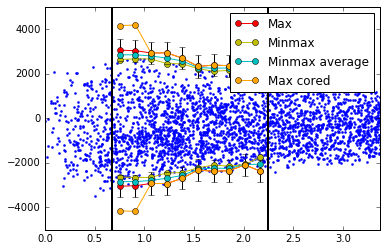

('2D Phase-space richness: ', 1587)


In [50]:
PLOTIT = True
j = 0                                  
if PLOTIT:
    plt.plot(r1_vec[:,j],v1_vec[:,j],'.',ms=4)
    plt.plot(r_fit[:,j], v_fit_max[:,j],'ro-', label = 'Max')
    plt.plot(r_fit[:,j], -v_fit_max[:,j],'ro-')
    plt.plot(r_fit[:,j], v_fit_minmax[:,j],'yo-', label = "Minmax")
    plt.plot(r_fit[:,j], -v_fit_minmax[:,j],'yo-')
    plt.plot(r_fit[:,j], v_fit_minmaxavg[:,j],'co-', label = 'Minmax average')
    plt.plot(r_fit[:,j], -v_fit_minmaxavg[:,j],'co-')
    plt.plot(r_fit[:,j], v_fit_max_cored[:,j],'o-',c='orange', label = 'Max cored')
    plt.plot(r_fit[:,j], -v_fit_max_cored[:,j],'o-',c='orange')
    plt.errorbar(r_fit[:,j],v_fit_max[:,j],yerr=v_fit_range[:,j],color='k', linestyle='None')
    plt.errorbar(r_fit[:,j],-v_fit_max[:,j],yerr=v_fit_range[:,j],color='k', linestyle='None')
    plt.ylim(-5000,5000)
    plt.xlim(0,1.5*r200)
    plt.legend()
    plt.axvline(r200,linewidth=2,color='k')
    plt.axvline(0.3*r200,linewidth=2,color='k')
    plt.show()
    w = np.where((r1 > 0.3*r200) & (r1 < r200))[0]
    text = "2D Phase-space richness: ", len(w)
    print(text)

In [54]:
one = 0
two = 9
R200_guess = 2.5
z = np.repeat(0.001, rotdo)
N = np.repeat(0,len(z))
p_z = np.repeat(z,len(z))
p_num_clus = num_clus
p_cosmo_params = cosmo_params
p_cosmo_name = cosmo_name
vesc_data_theta = np.zeros((rotdo,two-one))
vesc_data_r = np.zeros((rotdo,two-one))
vesc_data = np.zeros((rotdo,two-one))
vesc_data_err = np.zeros((rotdo,two-one))
for i in range(rotdo):
    N[i] = len(np.where((r1_vec[:,j] >0.3*R200_guess) & (r1_vec[:,j] <1.0*R200_guess))[0])
    vesc_data_theta[i,:] = (1000.0*r_fit[one:two,i])/(cosmo.kpc_proper_per_arcmin(z[i]))/60.0*np.pi/180.0
    vesc_data_r[i,:] = r_fit[one:two,i]
    vesc_data[i,:] = v_fit_max[one:two,i]
    vesc_data_err = v_fit_range[one:two,i]
num_clus = rotdo
print(num_clus)
print(np.shape(vesc_data_theta), np.shape(vesc_data), np.shape(vesc_data_r), np.shape(vesc_data_err),np.shape(z),np.shape(N), np.shape(cosmo_params))

vesc_data_theta_table = Table(vesc_data_theta,meta={'theta (radians)':1})
vesc_data_table = Table(vesc_data_theta,meta={'max edge (km/s)':1})
vesc_data_r_table = Table(vesc_data_theta,meta={'Mpc':1})
vesc_data_err_table = Table(vesc_data_theta,meta={'max/500 (km/s)':1})

if (aws == False):
    vesc_data_theta_table.write(vesc_data_theta_filename,overwrite=True)
    vesc_data_table.write(vesc_data_filename,overwrite=True)
    vesc_data_r_table.write(vesc_data_r_filename,overwrite=True)
    vesc_data_err_table.write(vesc_data_err_filename,overwrite=True)
else:
    vesc_data_theta_table.write(vesc_data_theta_local_filename,overwrite=True)
    vesc_data_table.write(vesc_data_local_filename,overwrite=True)
    vesc_data_r_table.write(vesc_data_r_local_filename,overwrite=True)
    vesc_data_err_table.write(vesc_data_err_local_filename,overwrite=True)

1
(1, 9) (1, 9) (1, 9) (9,) (1,) (1,) (2,)


In [55]:
def lnprior(omega):
    p_log10M200 = omega[0]
    if not(13 < p_log10M200 < 17 ):
          return -np.inf
    return 0.0

In [56]:
def lnlike(omega, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = np.repeat(10**omega[0],len(p_z))
    p_N = N
    p_num_clus = num_clus
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    ymodel_fixed = lambda p_theta_array,p_M200:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    rand = np.random.randint(0,1000)
    Zv1 = Zv_uniform(N,rand)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_M200)
    Zv_vec= np.transpose(np.repeat(Zv1[np.newaxis,:],len(vesc_data_r[0]),axis=0))
    ymodel = ymodel/Zv_vec
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [59]:
def lnprob(omega, x, y, yerr):
    lp = lnprior(omega)
    ll = lnlike(omega, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(omega, x, y, yerr)

In [60]:
ndim, nwalkers, nsteps = 1, 200, 1000
p0 = np.transpose([np.random.uniform(13,17,size=nwalkers)])#print np.shape(p0)

In [61]:
pool = Pool(processes=30)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(vesc_data_theta, vesc_data, vesc_data_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

State([[15.24174649]
 [15.2891535 ]
 [15.30543746]
 [15.30800774]
 [15.26340054]
 [15.28697843]
 [15.14944963]
 [15.23118118]
 [15.27214388]
 [15.24229811]
 [15.20715507]
 [15.25916265]
 [15.27986442]
 [15.2250761 ]
 [15.13432851]
 [15.30556347]
 [15.17067039]
 [15.18448488]
 [15.2874129 ]
 [15.19195106]
 [15.19838951]
 [15.21312644]
 [15.19139333]
 [15.2777189 ]
 [15.1893967 ]
 [15.2428143 ]
 [15.19981282]
 [15.26090073]
 [15.24555181]
 [15.1717874 ]
 [15.15966844]
 [15.17666352]
 [15.23070428]
 [15.24149506]
 [15.29842242]
 [15.10013475]
 [15.27569874]
 [15.13832977]
 [15.36738891]
 [15.24489261]
 [15.12027359]
 [15.21102675]
 [15.15155281]
 [15.26521837]
 [15.23705108]
 [15.14483825]
 [15.18351671]
 [15.24025302]
 [15.25079158]
 [15.13876234]
 [15.43152337]
 [15.20670492]
 [15.19408316]
 [15.27337818]
 [15.12680009]
 [15.18579444]
 [15.21735335]
 [15.13995043]
 [15.23866892]
 [15.4457467 ]
 [15.04969086]
 [15.0761798 ]
 [15.27338317]
 [15.27327651]
 [15.18201931]
 [15.23283558]
 [15

(200, 1000, 1)


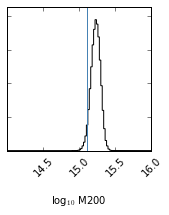

67
median(logM200) =  15.230372760730232 +/- 0.061497982750731595 0.06533058496443367
median(M200) =  1699701903304979.0 +/- 258559857500348.5 237382725117740.25
True:  [15.11069735]
/nfs/Christoq2/christoq/research4_new/caustics/darkskies/himass/edges/halo_9772120_mass_fit.txt


In [62]:
M200_use = [cluster_list['m200crit'][clus_num]/h0]
burn = 200
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print(np.shape(sampler.chain))
fig = corner.corner(samples[:,:], bins=100, labels=["log$_{10}$ M200"], range=[(14.0,16.0)],truths = [np.log10(M200_use)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print(len(percentile_array))
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print('median(logM200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print('median(M200) = ', 10**(M200_fit_50), '+/-', 10**(M200_fit_67)-10**(M200_fit_50), 10**(M200_fit_50) -10**(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('True: ', np.log10(M200_use))
if (aws == False):
    filename = mass_fit_filename
else:
    filename = mass_fit_local_filename
print(filename)
mass_out =  open(filename, 'w') 
text = 'median(logM200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33
print(text,file=mass_out)
text = 'median(M200) = ', 10**(M200_fit_50), '+/-', 10**(M200_fit_67)-10**(M200_fit_50), 10**(M200_fit_50) -10**(M200_fit_33)
print(text,file=mass_out)
text = 'True: ', np.log10(M200_use)
print(text,file=mass_out)
mass_out.close()